<a href="https://colab.research.google.com/github/benji555-create/Data-Science/blob/main/BGUnit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [3]:
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
#I could have put the url string directly into pd.read_csv()
cs_data = pd.read_csv(url_cs)
diff_TminusE = cs_data.theo - cs_data.exp
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)
aa_encode = pd.Categorical(cs_data['aa'])
aa_idx = aa_encode.codes
aa_coords = {"aa": aa_encode.categories}

In [4]:
with pm.Model(coords=aa_coords) as cs_h_model:

    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)


    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    idata_cs_h = pm.sample()

Output()

Output()

In [5]:
with pm.Model(coords=aa_coords) as cs_hstu_model:
    μ_mu = pm.StudentT('μ_mu', nu=5, mu = 0, sigma = 10)
    μ_sd = pm.HalfStudentT('μ_sd', nu=5, sigma = 10)
    ν_nu = pm.HalfStudentT('ν_nu', nu=5, sigma=10)


    μ = pm.StudentT('μ',
                  nu = ν_nu,
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfStudentT('σ', nu = 5, sigma = 10,
                      dims = "aa")

    ν = pm.HalfStudentT('ν', nu = 5, sigma = 10,
                      dims = "aa")


    y = pm.StudentT('y',
                  nu = ν[aa_idx],
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)


    idata_cs_hstu = pm.sample()

Output()

Output()

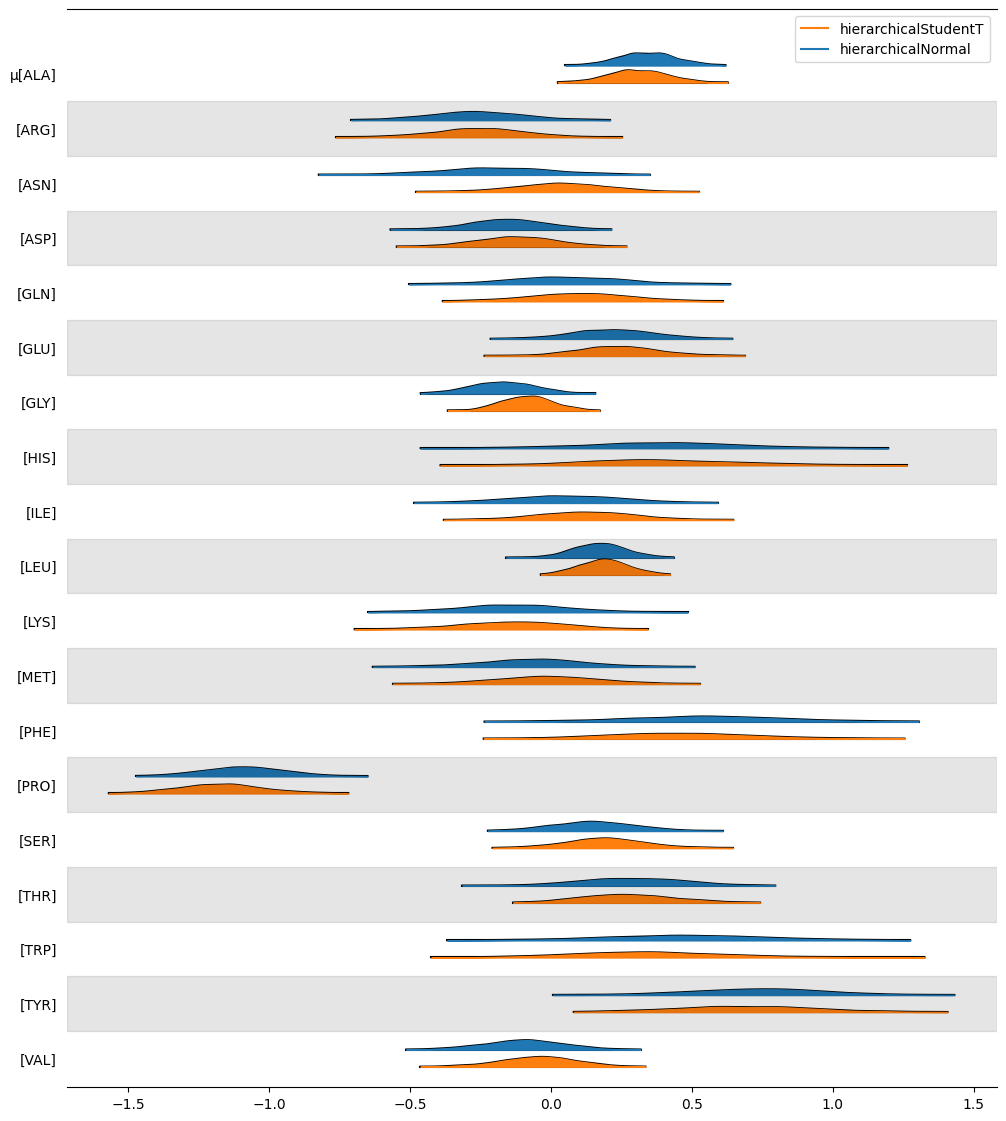

In [6]:
axes = az.plot_forest([idata_cs_h, idata_cs_hstu], kind="ridgeplot",
                      model_names=['hierarchicalNormal', 'hierarchicalStudentT'],
                      var_names='μ', combined=True, figsize=(12, 14),hdi_prob=0.997)

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

Output()

<Axes: xlabel='y'>

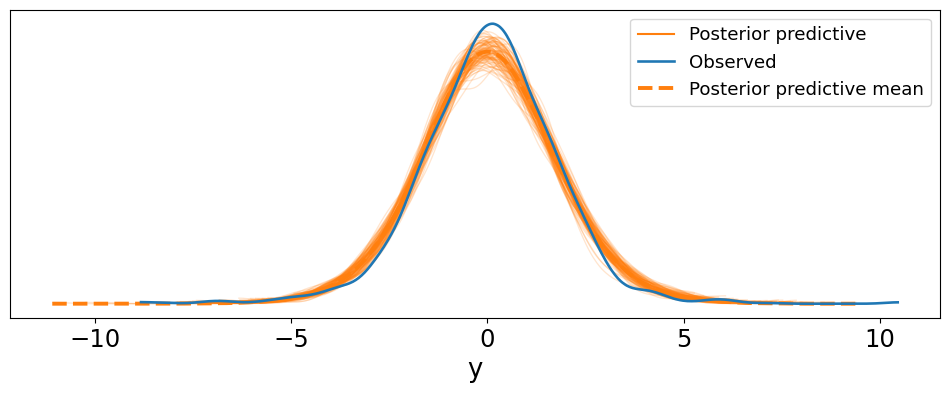

In [7]:
pm.sample_posterior_predictive(idata_cs_h, model=cs_h_model, extend_inferencedata=True)
az.plot_ppc(idata_cs_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

Output()

(-10.0, 10.0)

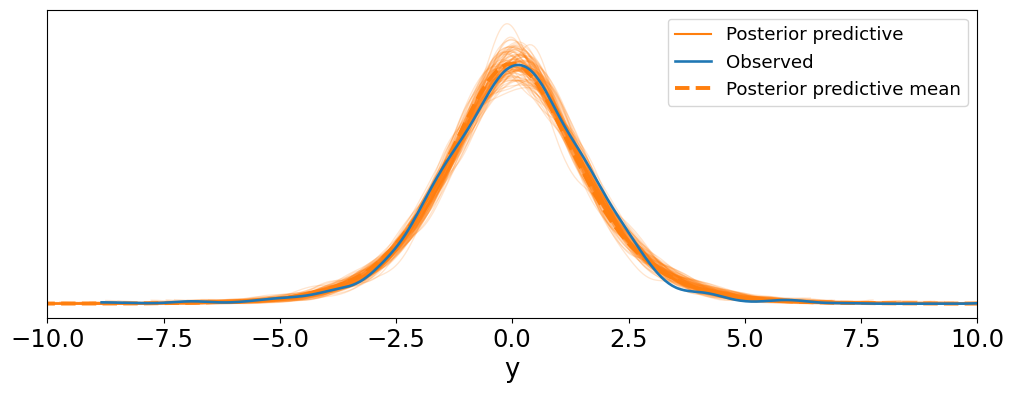

In [8]:
pm.sample_posterior_predictive(idata_cs_hstu, model=cs_hstu_model, extend_inferencedata=True)
ax=az.plot_ppc(idata_cs_hstu, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
ax.set_xlim(-10, 10)

The second model, or the one with student T and Hlaf Student T priors, is clearly more accurate. THe first model overestimates values towards the middle, while the Student T model fits it almost perfectly with a very slight underestimation around 3.0.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [9]:
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})
pos_idx = sccr_data.position.cat.codes.values

pos_codes = sccr_data.position.cat.categories


sccr_coords = {"pos": pos_codes}

In [10]:
with pm.Model(coords = sccr_coords) as sccr_model:


    μ_p = pm.Beta('μ_p', alpha = 2, beta = 20, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots per player
                    p = θ, #goals per shot
                    observed = sccr_data.goals.values) #goals per player

    idata_sccr = pm.sample(target_accept = 0.98)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.001 1.003 1.002 1.001 ... 1.003 1.0 1.003
    μ_p      (pos) float64 32B 1.001 1.002 1.037 1.0
    ν_p      (pos) float64 32B 1.036 1.006 1.046 1.003

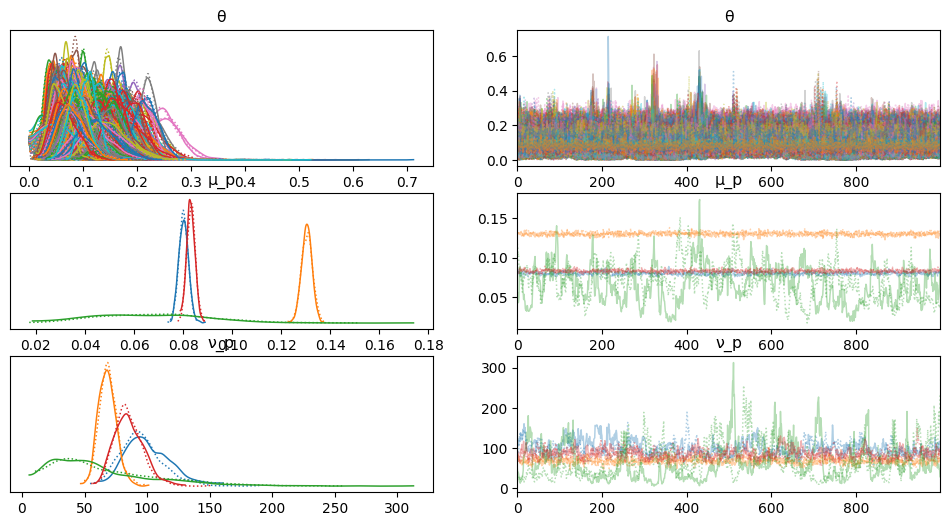

In [11]:
az.plot_trace(idata_sccr)
az.rhat(idata_sccr)

The r hat values for the non-hierarchical model are closer to 1 and 1.001. The ones not in this range aren't far off.
The values for Goalies don't go beyond 1.1. They are under 1.09 which is not ideal. This is much better than the 1.242 from the answer key.

The plot traces are similar. All peaks have the lines follwoing similar trajectories, although the ν_p model is cleaner.

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

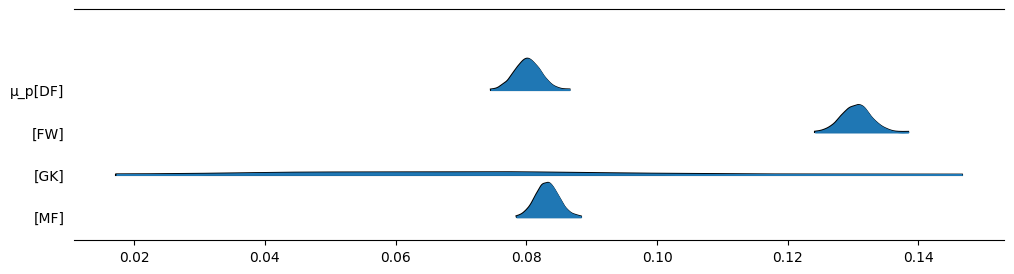

In [12]:
az.plot_forest(idata_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

These posteriors are much more certain than the ones from class, as they are much smoother and are more narrow.


**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [13]:
sccr_data_noGoalies = sccr_data[sccr_data.position != 'GK'].copy()
sccr_data_noGoalies['position'] = pd.Categorical(sccr_data_noG['position'])
sccr_data_noGoalies['position'] = sccr_data_noG['position'].cat.remove_unused_categories()

In [14]:
pos_idx_noGoalies = sccr_data_noGoalies.position.cat.codes.values

pos_codes_noGoalies = sccr_data_noGoalies.position.cat.categories

sccr_coords_noGoalies = {"pos": pos_codes_noGoalies}

print(pos_codes_noGoalies)
print(sccr_coords_noGoalies)

Index(['DF', 'FW', 'MF'], dtype='object')
{'pos': Index(['DF', 'FW', 'MF'], dtype='object')}


In [15]:
with pm.Model(coords = sccr_coords_noG) as sccr_model_noGoalies:
    # Hyper parameters
    #
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx_noGoalies], nu = ν_p[pos_idx_noGoalies])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data_noGoalies.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data_noGoalies.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr_noGoalies = pm.sample(target_accept = 0.95)



Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

array([<Axes: >], dtype=object)

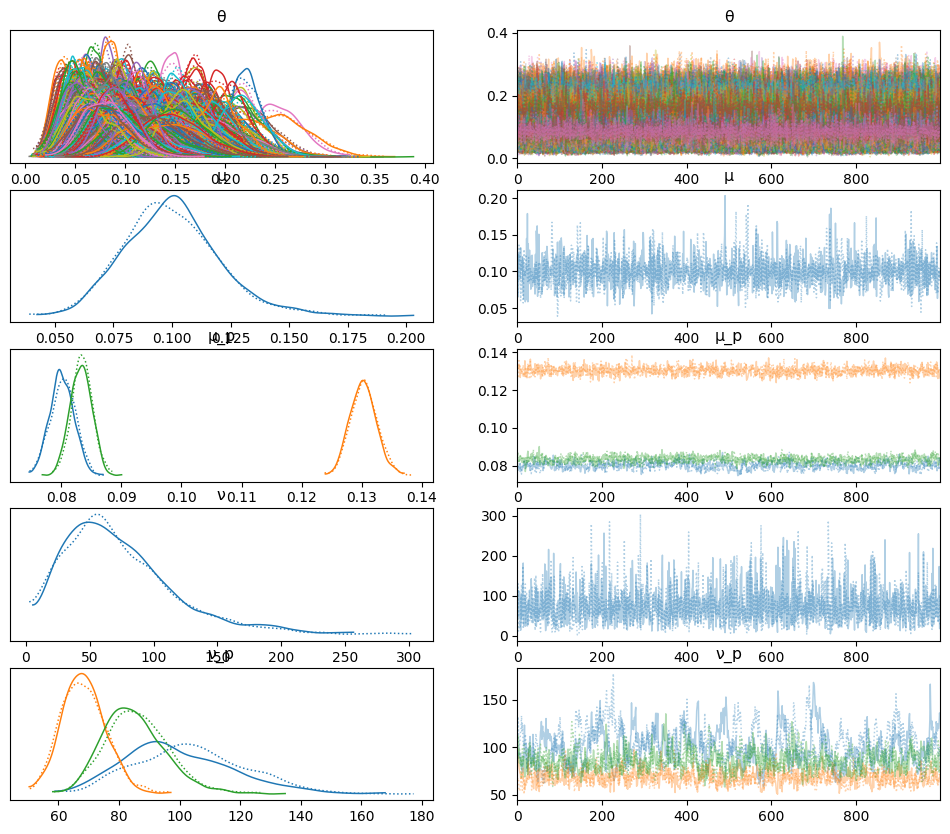

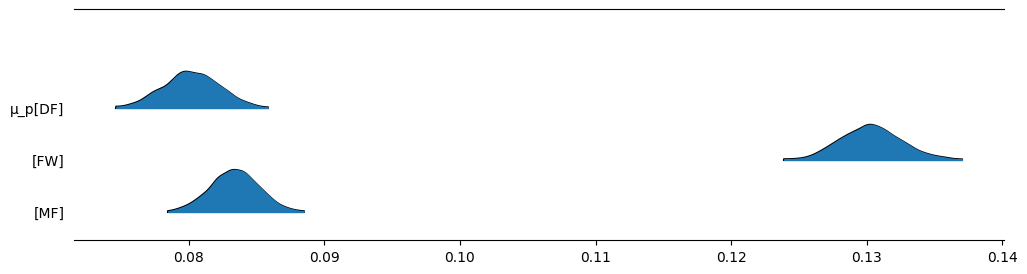

In [16]:
az.plot_trace(idata_sccr_noGoalies)
az.rhat(idata_sccr_noGoalies)
az.plot_forest(idata_sccr_noGoalies, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

The model with no Goalies(or no outliers) is much neater. It was easier to process, taking 6 mins versus the orgiinal 10. We don't lose much, besides the very low possibility of when they do wind up scoring and we technically "forget" that keepers even exist. These losses are made up for with the fact that you gain efficiancy, accuracy, clarity, simplitcity, time, and more. It's much simpler overall without goalies.
